In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("gold_monthly.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [3]:
df.shape

(847, 2)

In [4]:
print(f"Date range of gol prices available from - {df.loc[:, 'Date'][0]} to {df.loc[:, 'Date'][len(df)-1]}")

Date range of gol prices available from - 1950-01 to 2020-07


In [5]:
date = pd.date_range (start = '1/1/1950', end = '8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [6]:
df['month'] = date
df.drop('Date', axis = 1, inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


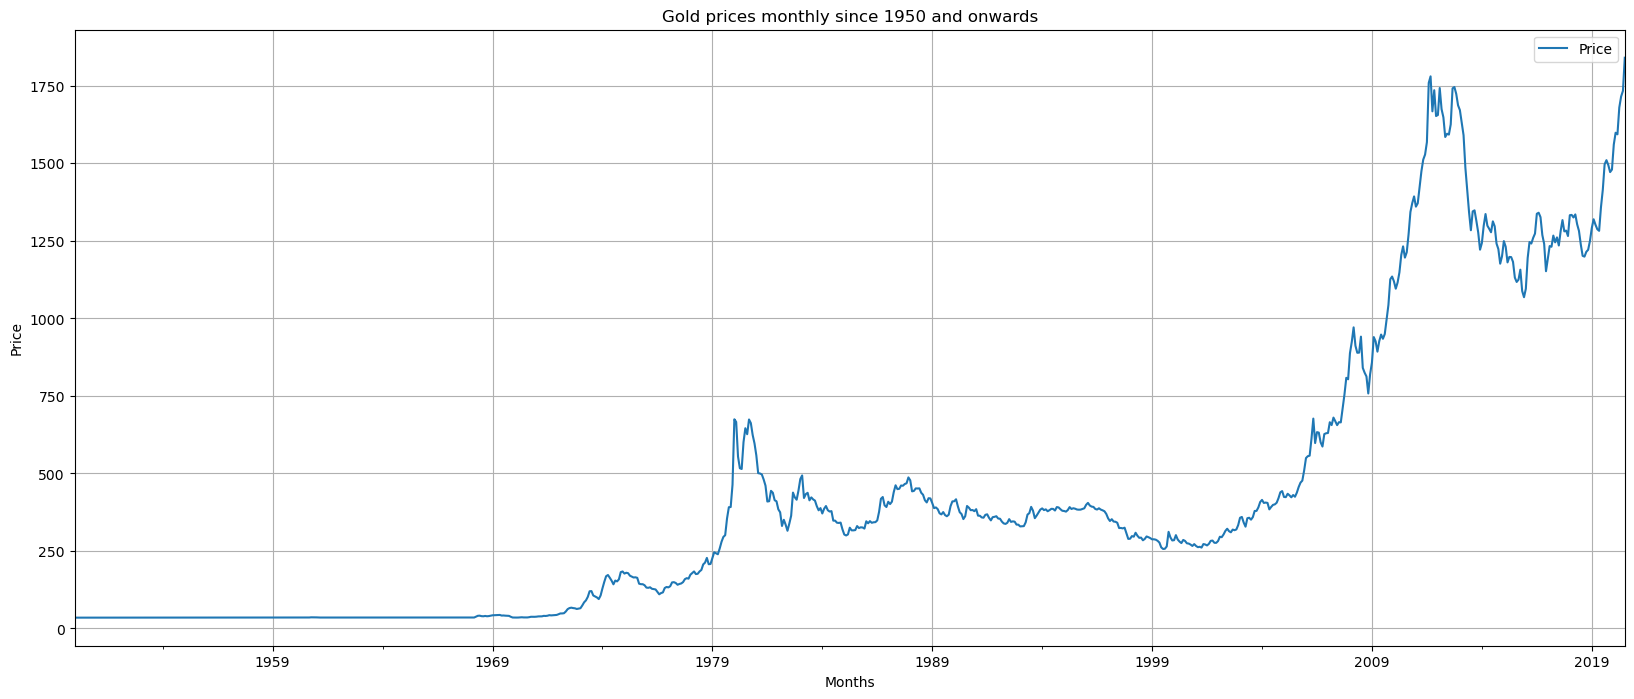

In [7]:
df.plot(figsize=(20,8))
plt.title("Gold prices monthly since 1950 and onwards")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()

In [8]:
round(df.describe(), 3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


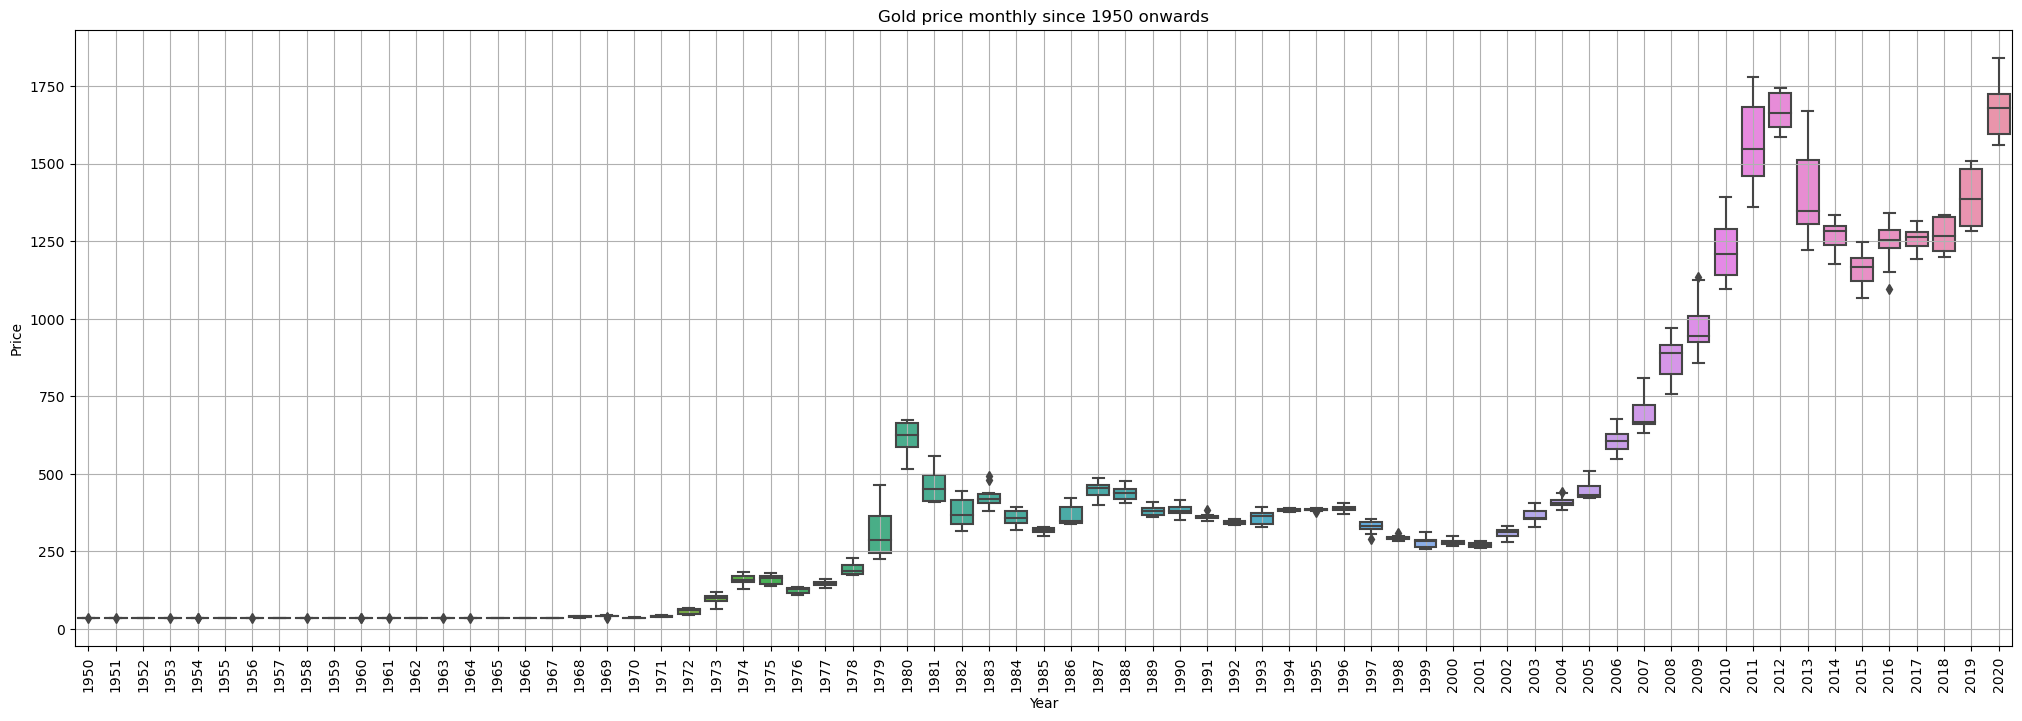

In [9]:
_, ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year, y = df.values[:,0], ax=ax)
plt.title('Gold price monthly since 1950 onwards')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.grid()

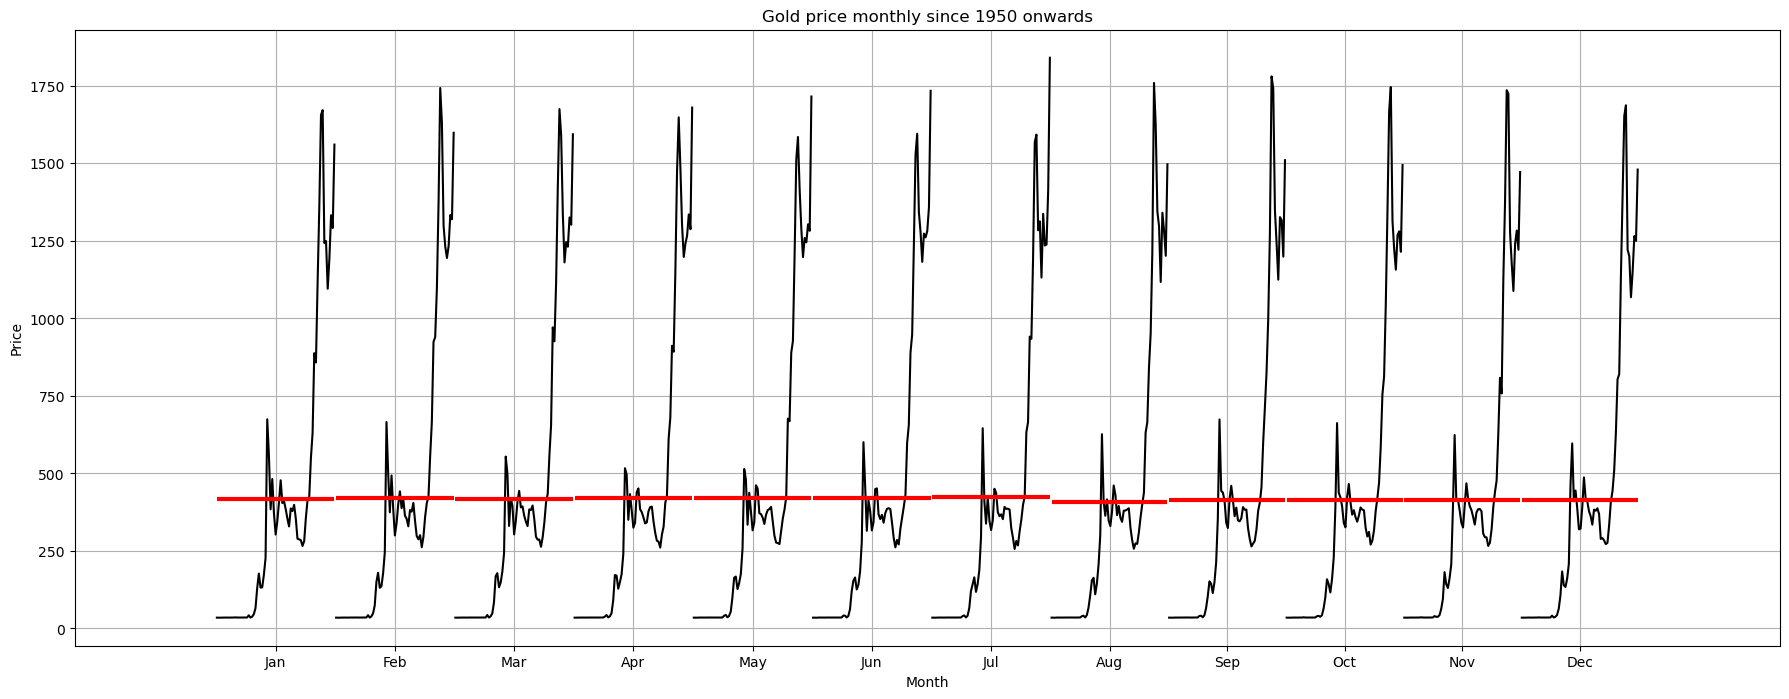

In [10]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))
month_plot(df, ylabel = 'Gold price', ax=ax)
plt.title('Gold price monthly since 1950 onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid()

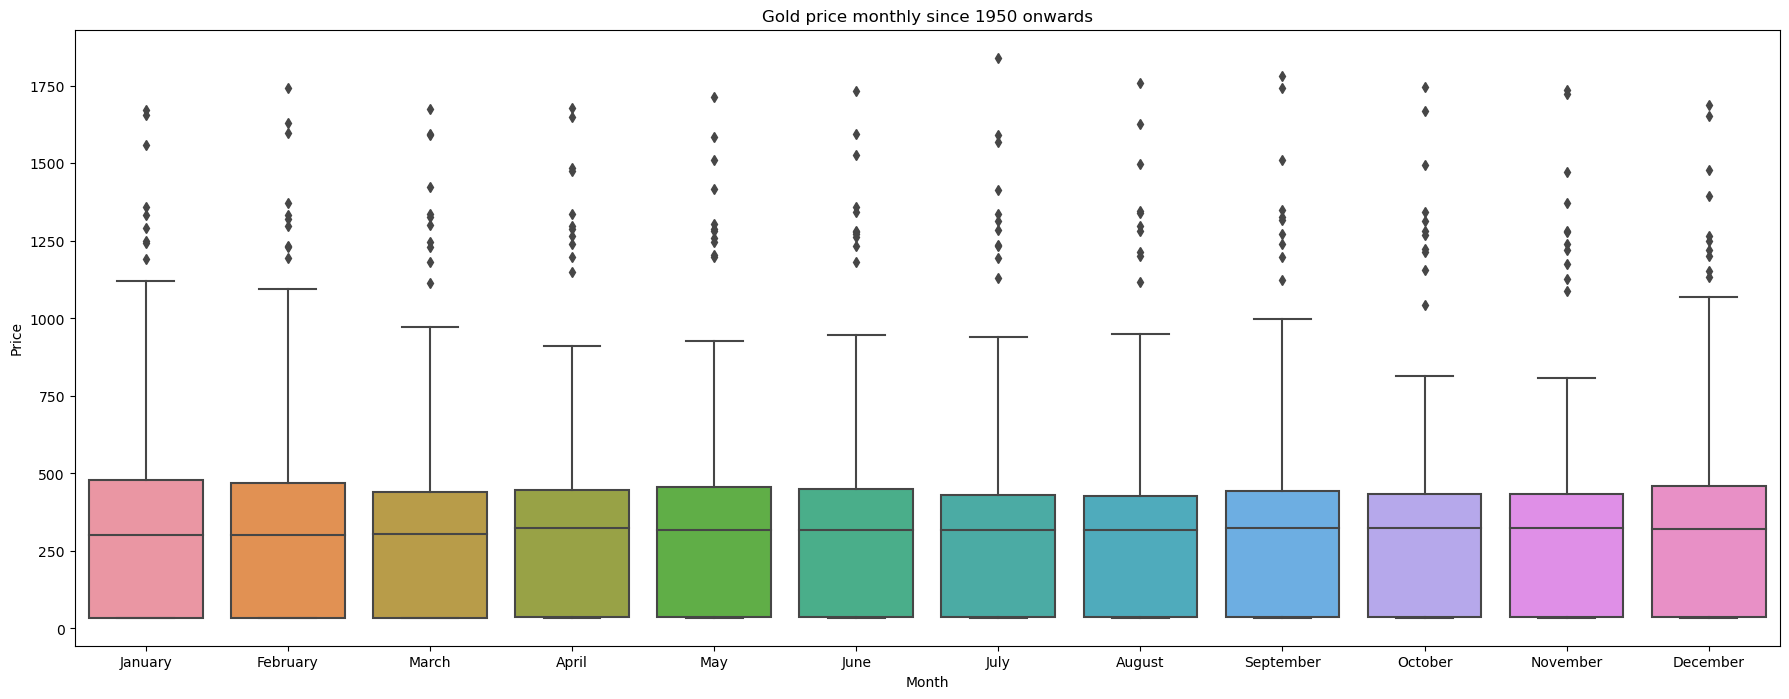

In [11]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(), y= df.values[:,0], ax = ax)
plt.title('Gold price monthly since 1950 onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

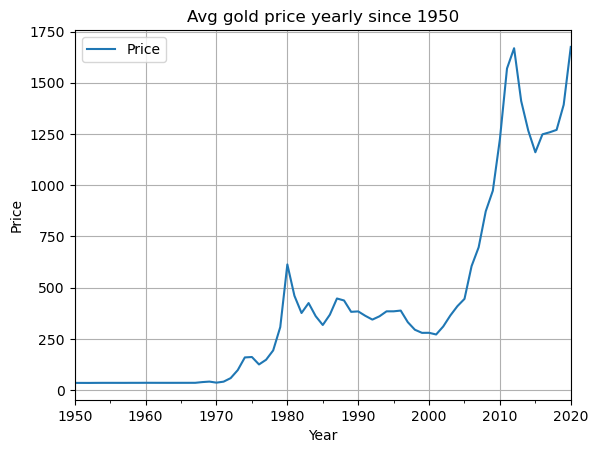

In [12]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title("Avg gold price yearly since 1950")
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid()

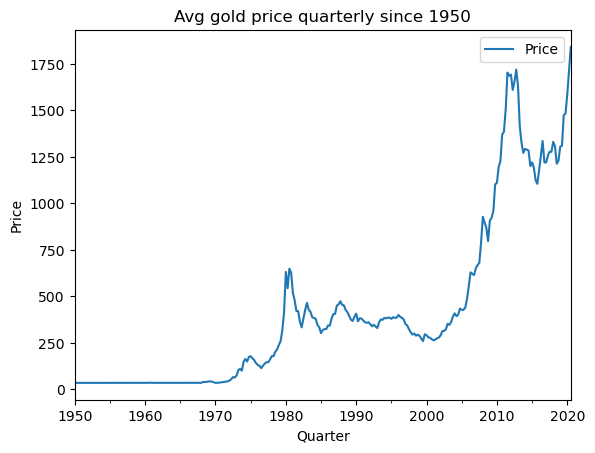

In [13]:
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot()
plt.title("Avg gold price quarterly since 1950")
plt.xlabel('Quarter')
plt.ylabel("Price")
plt.show()

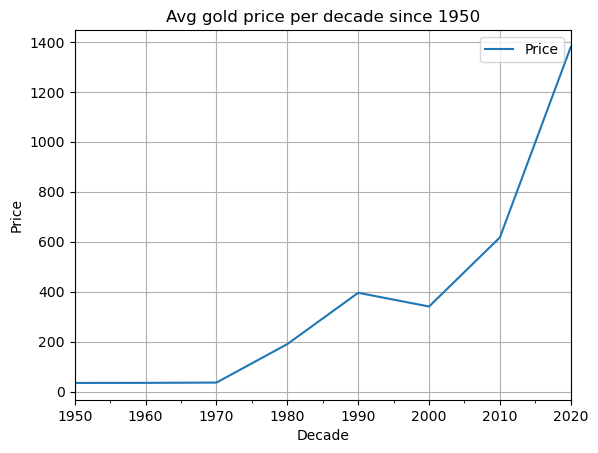

In [14]:
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('Avg gold price per decade since 1950')
plt.xlabel('Decade')
plt.ylabel('Price')
plt.grid()

In [15]:
df_1 = df.groupby(df.index.year).mean().rename(columns = {'Price' : 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price' : 'Std'}), left_index = True, right_index = True)
df_1['Cov_pct'] = ((df_1['Std'] / df_1['Mean'])*100).round(2)
df_1.head()

,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


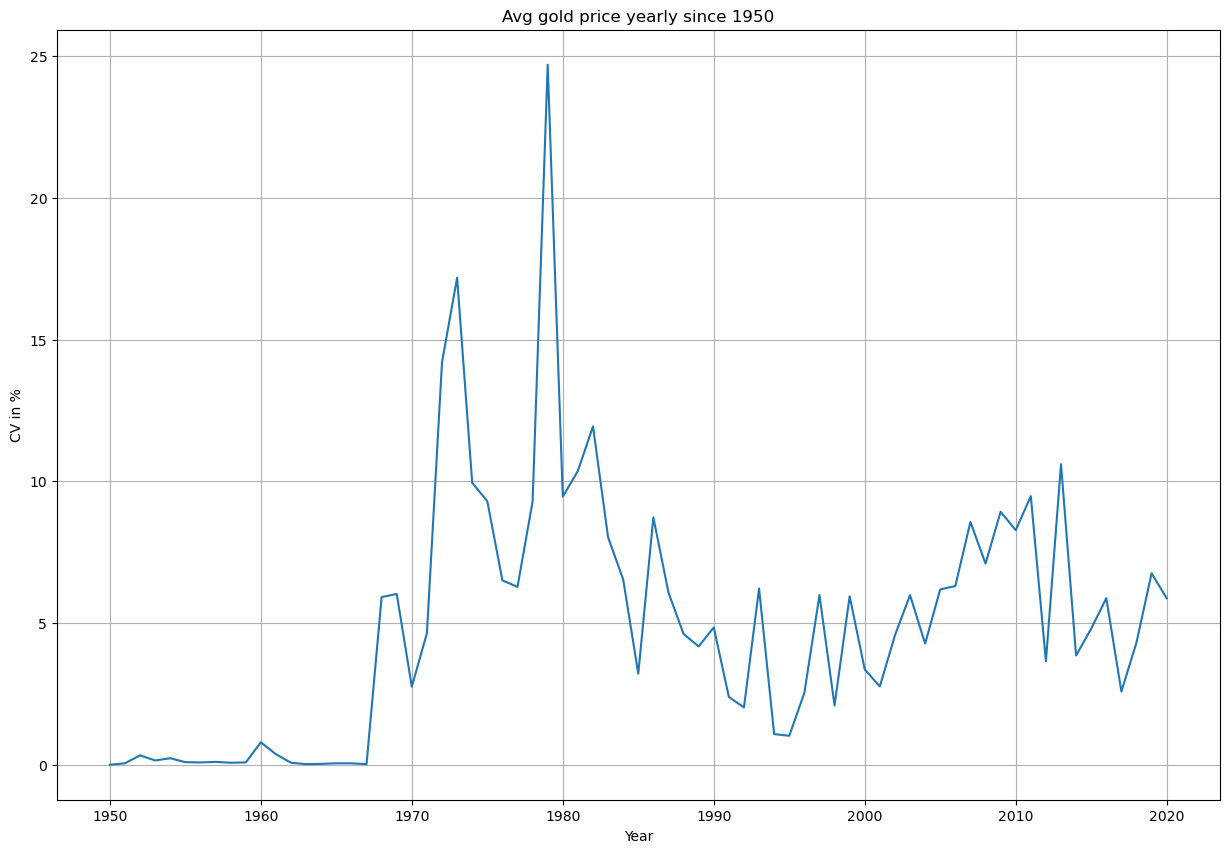

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
df_1['Cov_pct'].plot()
plt.title('Avg gold price yearly since 1950')
plt.xlabel('Year')
plt.ylabel('CV in %')
plt.grid()

In [17]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [18]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


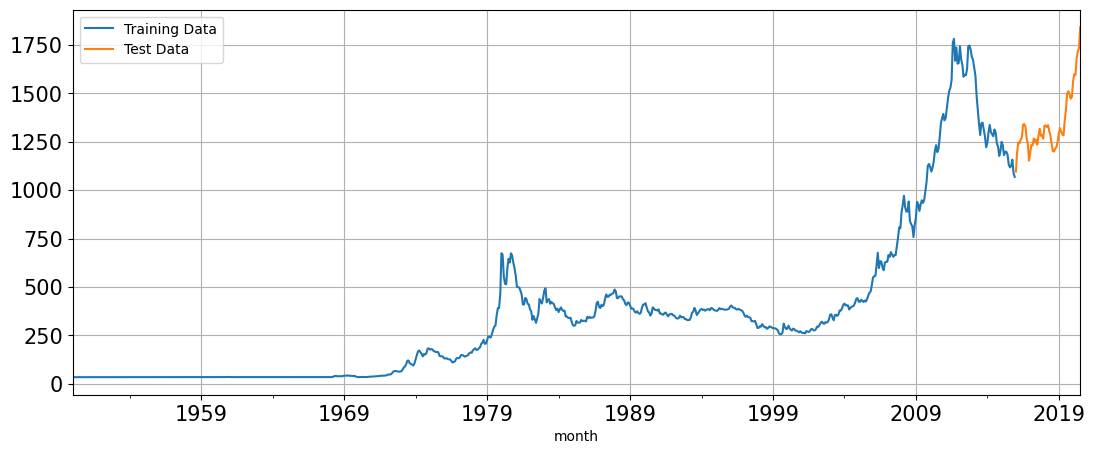

In [19]:
train['Price'].plot(figsize=(13,5), fontsize = 15)
test['Price'].plot(figsize=(13,5), fontsize = 15)
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show()

In [20]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+i for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [21]:
LR_train = train.copy()
LR_test = test.copy()

In [22]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [24]:
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

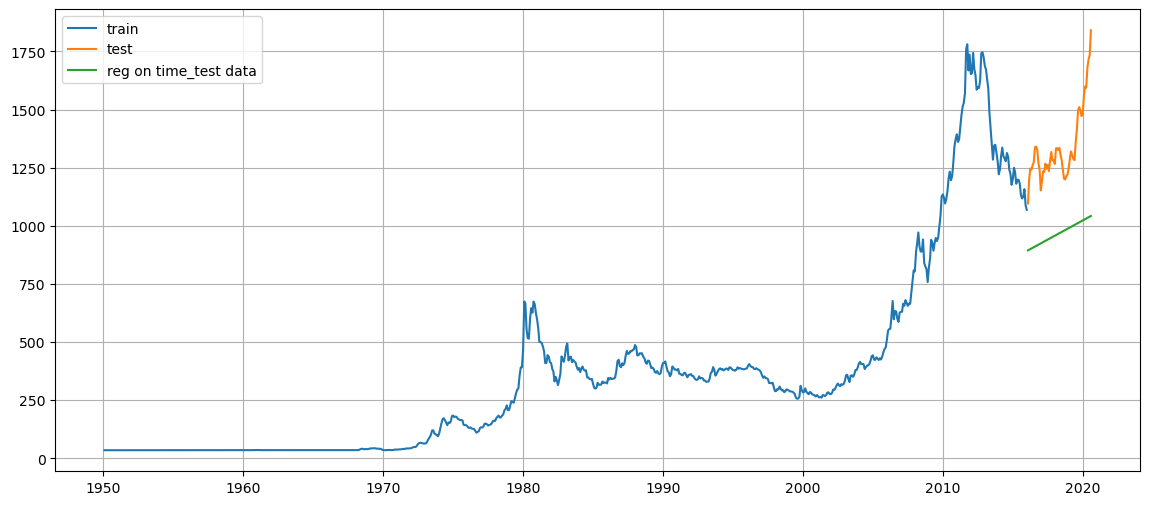

In [33]:
test_predictions_model1 = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1
plt.figure(figsize = (14,6))
plt.plot(train['Price'], label = 'train')
plt.plot(test['Price'], label = 'test')
plt.plot(LR_test['forecast'], label = 'reg on time_test data')
plt.legend(loc = 'best')
plt.grid()

In [38]:
def mape(actual, pred): 
    return round((np.mean(abs(actual - pred)/ actual))*100, 2)

In [41]:
mape_model1_test = mape(test['Price'].values, test_predictions_model1)
print('MAPE is %3.3f'%(mape_model1_test), '%')

MAPE is 27.200 %


In [44]:
results = pd.DataFrame({'Test Mape (%)' : [mape_model1_test]}, index=['RegressionOnTime'])
results

,Test Mape (%)
RegressionOnTime,27.2


In [46]:
Naive_train = train.copy()
Naive_test = test.copy()

In [47]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

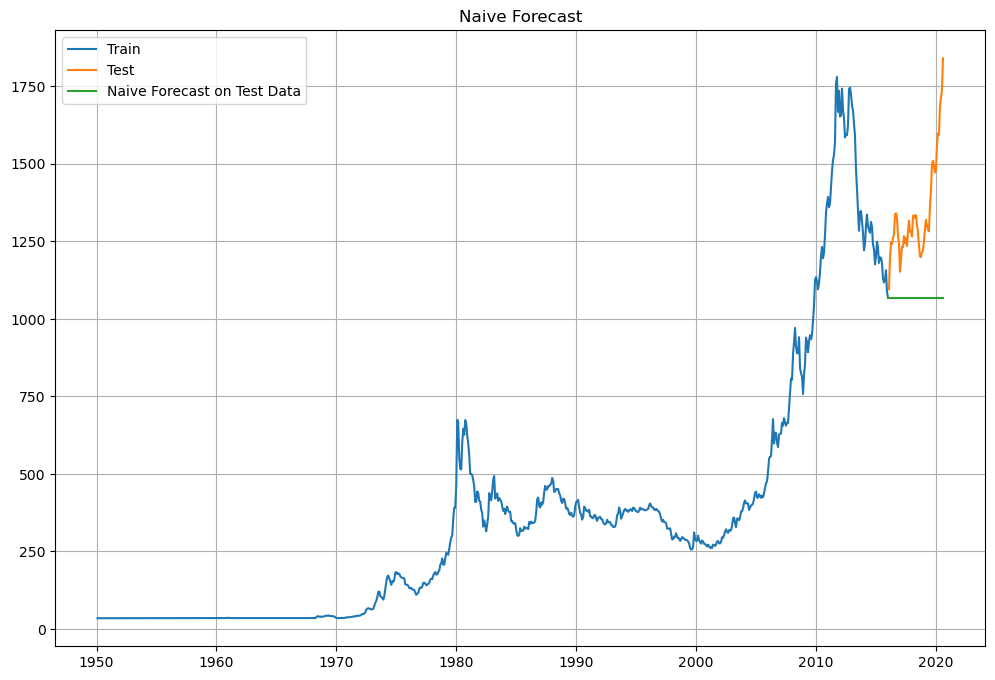

In [48]:
plt.figure(figsize=(12,8))
plt.plot(Naive_train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(Naive_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()

In [50]:
mape_model2_test = mape(test['Price'].values, Naive_test['naive'].values)
print('For Naive forecast on the Test Data, MAPE is %3.3f' %(mape_model2_test), '%')

For Naive forecast on the Test Data, MAPE is 19.380 %


In [51]:
resultsDf_2 = pd.DataFrame({'Test MAPE (5)' : [mape_model2_test]}, index=['NaiveModel'])
results = pd.concat([results, resultsDf_2])
results

,Test Mape (%),Test MAPE (5)
RegressionOnTime,27.2,NaN
NaiveModel,NaN,19.38


In [52]:
final_model = ExponentialSmoothing(df,
                                  trend = 'additive',
                                  seasonal = 'additive').fit(smoothing_level = 0.4,
                                                            smoothing_trend = 0.3,
                                                            smoothing_seasonal = 0.6)

In [56]:
Mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print('MAPE:', Mape_final_model)

MAPE: 17.24


In [57]:
predictions = final_model.forecast(steps=len(test))

In [59]:
pred_df = pd.DataFrame({'lower_CI': predictions - 1.96*np.std(final_model.resid, ddof=1),
                       'prediction': predictions,
                       'upper_CI':predictions+1.96*np.std(final_model.resid, ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.713703,1792.864676,1901.015650
2020-09-30,1615.291065,1723.442039,1831.593012
2020-10-31,1538.543199,1646.694172,1754.845146
2020-11-30,1476.724385,1584.875359,1693.026332
2020-12-31,1459.285045,1567.436019,1675.586992


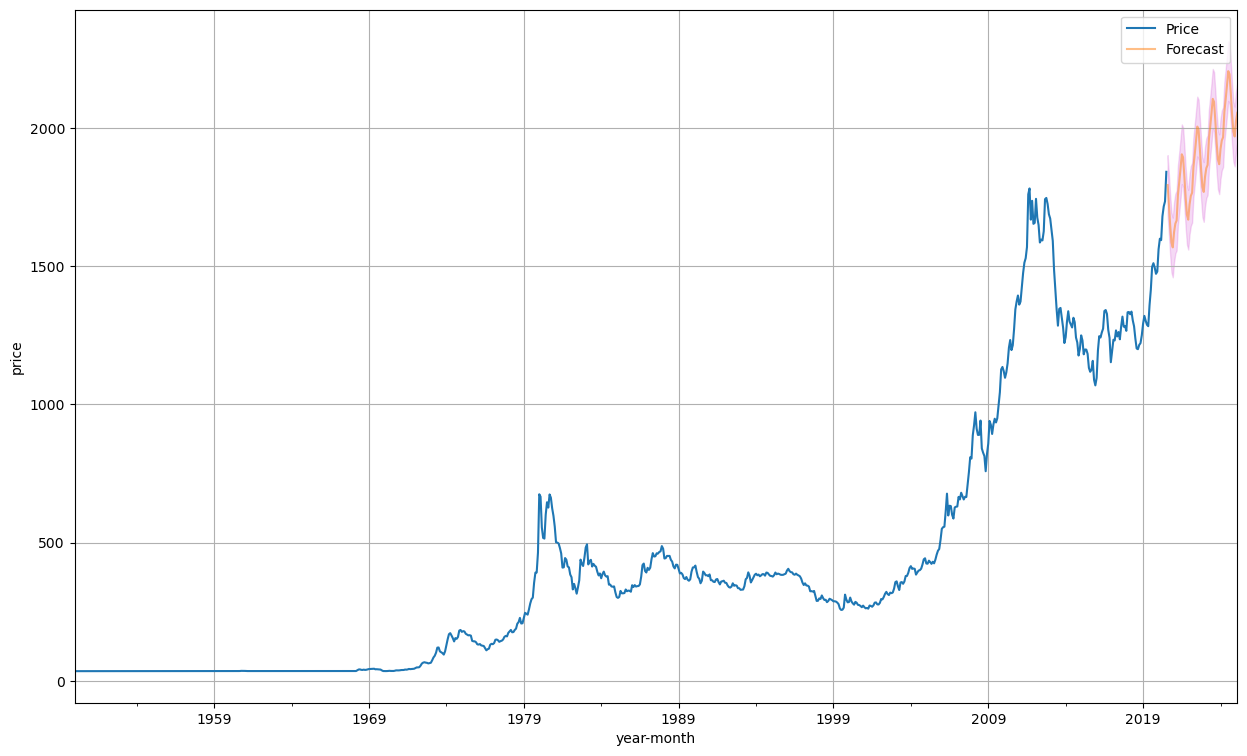

In [61]:
axis = df.plot(label = 'Actual', figsize=(15,9))
pred_df['prediction'].plot(ax= axis, label = 'Forecast', alpha = 0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color = 'm', alpha = .15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.legend(loc = 'best')
plt.grid()
plt.show()